In [1]:
import cv2

import os
import random
from rasterio.features import shapes
import matplotlib.pyplot as plt
import numpy as np
import rasterio

from osgeo import ogr, gdal
from torchvision.transforms import transforms
from tqdm import tqdm
from shapely.geometry import polygon
from utils import generate_patch_coordinates



In [2]:
dataset_dir = os.path.join('D:','Data Ayush','Barahi')
image_dir = r"D:\Data Ayush\Barahi\Orthomosaic"
mask_dir = r"C:\Users\Asus\Documents\ArcGIS\Projects\MyProjectBarahi"
current_image_file_name = "Orthomosaic.tif"
current_mask_file_name = "Building.shp"

# Path to the image file in .tif format
image_path = os.path.join(image_dir, current_image_file_name)
# Path to the shape file containing the landcover classes in .shp format
mask_path = os.path.join(mask_dir,
                         current_mask_file_name)
# Path to the shape file containing the landcover classes in .shp format
# mask_path = os.path.join(mask_dir,
#                          current_mask_file_name)
output_dir = os.path.join('.', 'output8')
os.makedirs(output_dir, exist_ok=True)

rasterized_dir = os.path.join(output_dir, 'rasterized_outputs')
os.makedirs(rasterized_dir, exist_ok=True)
# rasterized_dir = os.path.join(output_dir, 'rasterized_outputs')
# os.makedirs(rasterized_dir, exist_ok=True)
rasterized_file_name = "Result.tif"
rasterized_file_path = os.path.join(rasterized_dir, rasterized_file_name)
patch_size = 640
stride = 320
boundary = [3053710.461731, 751158.377075, 3055429.699707, 753175.112122]
patch_output_dir = os.path.join(output_dir, f"{patch_size}x{patch_size}")
os.makedirs(patch_output_dir, exist_ok=True)
labels_output_dir = os.path.join(patch_output_dir, 'labels')
os.makedirs(labels_output_dir, exist_ok=True)




In [3]:
mask_shape_file_path = mask_path
image_file_path = image_path

gdalformat = 'GTiff'
datatype = gdal.GDT_Float32

# Get projection info from reference image
Image = gdal.Open(image_file_path, gdal.GA_ReadOnly)

# Open Shapefile
Shapefile = ogr.Open(mask_shape_file_path)
Shapefile_layer = Shapefile.GetLayer()

# Rasterise
print("Rasterizing shapefile...")

Output = gdal.GetDriverByName(gdalformat).Create(rasterized_file_path, Image.RasterXSize, Image.RasterYSize, 1,
                                                 datatype,
                                                 options=['COMPRESS=DEFLATE'])
Output.SetProjection(Image.GetProjectionRef())
Output.SetGeoTransform(Image.GetGeoTransform())

# Write data to band 1
Band = Output.GetRasterBand(1)
Band.SetNoDataValue(0)

gdal.RasterizeLayer(Output, [1], Shapefile_layer, options=['ATTRIBUTE=Class_Id'])

# Close datasets
Band = None
Output = None
Image = None
Shapefile = None

print("Rasterization of shapefile completed.")

c:\Users\Asus\anaconda3\envs\crowdcounting\lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Rasterizing shapefile...
Rasterization of shapefile completed.


In [4]:
# Open the rasters
with rasterio.open(image_path) as raster1:
    temp_img = raster1.read()  # Read raster1 into numpy array

with rasterio.open(rasterized_file_path) as raster2:
    temp_mask = raster2.read(1)  # Read raster2 into numpy array

labels, count = np.unique(temp_mask, return_counts=True)  #Check for each channel. All channels are identical
print('Unique values in mask: ', labels)
print('Counts of unique values: ', count)

MemoryError: Unable to allocate 58.3 GiB for an array with shape (4, 142802, 109586) and data type uint8

In [4]:
with rasterio.open(rasterized_file_path, "r") as src:
    mask_data = src.read()
    
    mask_meta = src.meta

print(np.unique(mask_data))

MemoryError: Unable to allocate 17.5 GiB for an array with shape (1, 46296, 101711) and data type float32

In [4]:
from utils import create_patches
# image_path="C:\\Users\\bhatt\\OneDrive\Desktop\\butwal data\\Orthomosaics Output\\Butwal Orthomosaics Only\\Mission 1.tif"
# rasterized_file_path="C:\\Users\\bhatt\\OneDrive\\Desktop\\semprj\\aerial-satellite-imagery-segmentation-nepal\\output11\\rasterized_outputs\\Result11.tif"
# patch_size= 513
# stride=256
# patch_output_dir="C:\\Users\\bhatt\\OneDrive\\Desktop\\semprj\\aerial-satellite-imagery-segmentation-nepal\\output11\\513x513"
create_patches(image_path, rasterized_file_path, patch_output_dir, patch_size, stride)

KeyboardInterrupt: 

In [ ]:
# patch_output_dir=r"D:\Drone-Image-Based-Landcover-Segmentation\output\513x513"
# image_files = [f for f in os.listdir(patch_output_dir + "\\images") if f.endswith('.tif')]

# # Select a random image file
# random_image_file = random.choice(image_files)

# # Construct the full paths to the image and mask files
# temp_image_path = os.path.join(patch_output_dir, "images", random_image_file)
# temp_mask_path = os.path.join(patch_output_dir, "masks", random_image_file.replace('.tif', '_mask.tif'))

# # Open the image and mask files using Rasterio
# with rasterio.open(temp_image_path) as src:
#     image = src.read().astype(float)
#     image_transform = src.transform

# with rasterio.open(temp_mask_path) as src:
#     mask = src.read()
#     mask_transform = src.transform

# # The image data read by Rasterio is in (bands, rows, cols) order
# # Convert the image data to (rows, cols, bands) order for visualization
# transposed_image = image.transpose((1, 2, 0))

# if 0 not in np.unique(transposed_image):
#     # Scale the image data to be between 0 and 1 for better visualization
#     transposed_image -= transposed_image.min()
#     transposed_image /= transposed_image.max()

#     # Create plots
#     fig, ax = plt.subplots(1, 2, figsize=(15, 15))

#     # Display the image
#     ax[0].imshow(transposed_image)
#     ax[0].set_title("Image")

#     # Display the mask
#     transposed_mask = mask.transpose((1, 2, 0))

#     ax[1].imshow(transposed_mask)
#     ax[1].set_title("Mask")
#     print(np.unique(mask))

#     plt.tight_layout()

#     plt.show()


#     print('Image shape: ', image.shape)
#     print('Mask shape: ', mask.shape)
# else:
#     print("Blank data")

: 

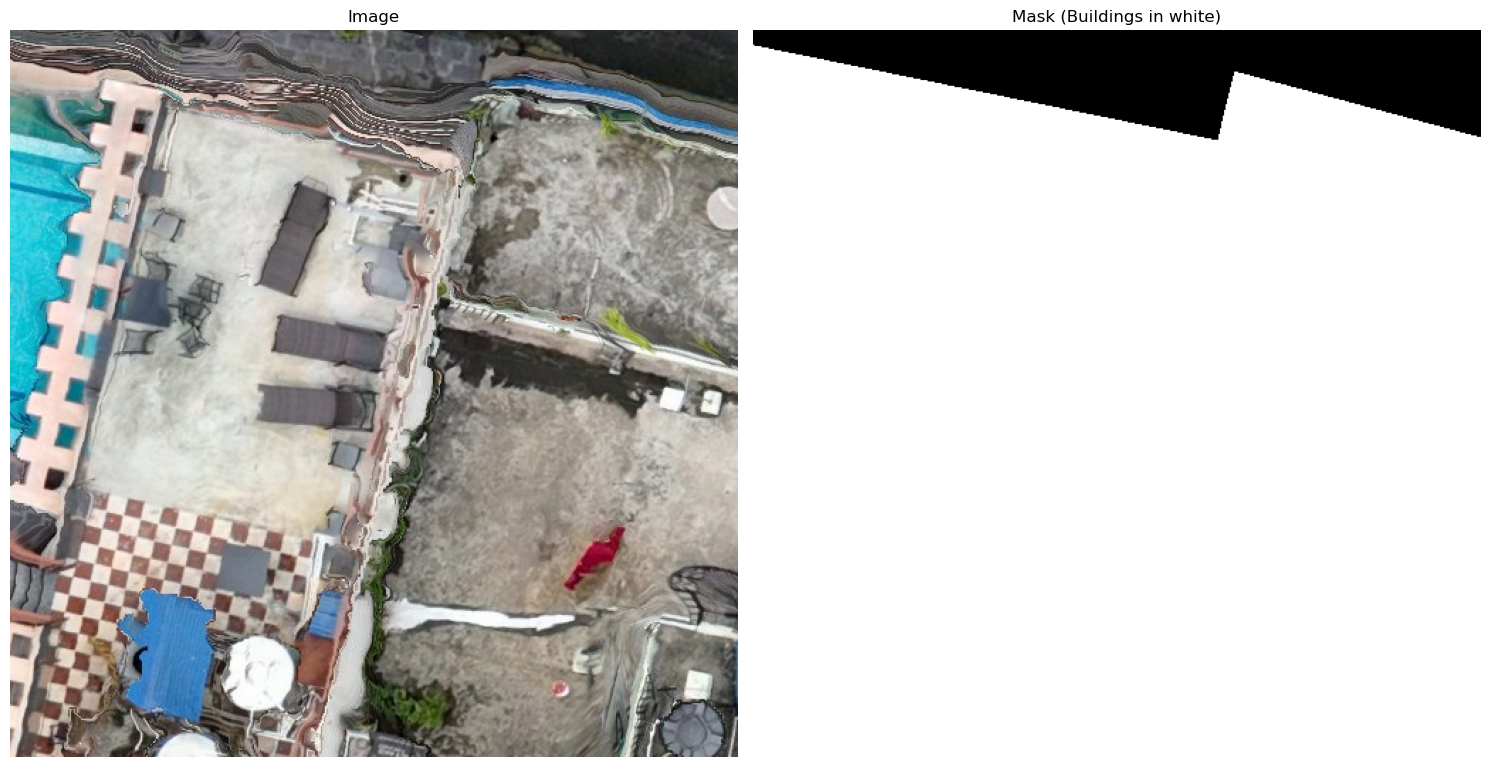

Image shape (bands, height, width): (4, 513, 513)
Mask shape (height, width): (513, 513)
Unique values in mask: [0 1]


In [4]:
import os
import random
import rasterio
import numpy as np
import matplotlib.pyplot as plt

patch_output_dir = r"D:\Drone-Image-Based-Landcover-Segmentation\output1\513x513"

# List all image files
image_files = [f for f in os.listdir(os.path.join(patch_output_dir, "images")) if f.endswith('.tif')]

# Select a random image file
random_image_file = random.choice(image_files)

# Paths
temp_image_path = os.path.join(patch_output_dir, "images", random_image_file)
temp_mask_path = os.path.join(patch_output_dir, "masks", random_image_file.replace('.tif', '_mask.tif'))

# Open image
with rasterio.open(temp_image_path) as src:
    image = src.read().astype(float)
    image_transform = src.transform

# Open mask
with rasterio.open(temp_mask_path) as src:
    mask = src.read(1)  # single channel
    mask_transform = src.transform

# Transpose image to (rows, cols, bands)
transposed_image = image.transpose((1, 2, 0))

# Normalize image for visualization
if transposed_image.max() > 1.0:
    transposed_image -= transposed_image.min()
    transposed_image /= transposed_image.max()

# Visualize mask (scale 0/1 → 0/255 for display only)
visual_mask = mask * 255  # **only for plotting**
visual_mask = visual_mask.astype(np.uint8)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(transposed_image)
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(visual_mask, cmap='gray')
ax[1].set_title("Mask (Buildings in white)")
ax[1].axis('off')

plt.tight_layout()
plt.show()


# Info
print('Image shape (bands, height, width):', image.shape)
print('Mask shape (height, width):', mask.shape)
print('Unique values in mask:', np.unique(mask))


In [ ]:
# import matplotlib.pyplot as plt
# import os
# import random
# import rasterio
# import numpy as np


# # Get list of image files
# image_files = [f for f in os.listdir(patch_output_dir + "\\images") if f.endswith('.jpg')]
# print(image_files)
# # Select a random image file
# random_image_file = random.choice(image_files)

# # Construct the full paths to the image and mask files
# temp_image_path = os.path.join(patch_output_dir, "images", random_image_file)
# temp_mask_path = os.path.join(patch_output_dir, "masks", random_image_file.replace('.jpg', '_mask.jpg'))

# # Open the image and mask files using Rasterio
# with rasterio.open(temp_image_path) as src:
#     image = src.read().astype(float)
#     image_transform = src.transform
# # temp_mask_path=r"C:\Users\bhatt\OneDrive\Desktop\semprj\aerial-satellite-imagery-segmentation-nepal\Output_mg\513x513\masks\test\Mission4patch_955_mask.jpg"

# with rasterio.open(temp_mask_path) as src:
#     mask = src.read()
#     mask_transform = src.transform
# print(np.unique(mask))
# # The image data read by Rasterio is in (bands, rows, cols) order
# # Convert the image data to (rows, cols, bands) order for visualization
# transposed_image = image.transpose((1, 2, 0))

# # Scale the image data to be between 0 and 1 for better visualization
# transposed_image -= transposed_image.min()
# transposed_image /= transposed_image.max()

# # Create plots
# fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# # Display the image
# ax[0].imshow(transposed_image)
# ax[0].set_title("Image")

# # Display the first channel of the mask
# ax[1].imshow(mask[0,:,:], cmap='gray')
# ax[1].set_title("Mask Channel 1")

# # Display the second channel of the mask
# ax[2].imshow(mask[1,:,:], cmap='gray')
# ax[2].set_title("Mask Channel 2")

# plt.tight_layout()
# plt.show()
# # Create plots
# # fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# # # Combine the channels into a single image
# # combined_mask = np.stack((mask[0,:,:], mask[1,:,:], np.zeros_like(mask[0,:,:])), axis=-1)

# # # Display the combined mask
# # ax.imshow(combined_mask)
# # ax.set_title("Combined Mask")

# # plt.tight_layout()
# # plt.show()



# print('Image shape:', image.shape)
# print('Mask shape:', mask.shape)


[]


IndexError: list index out of range

Total image files: 3750

Processing: Pokharapatch_1885.tif
Unique values in mask: [1]


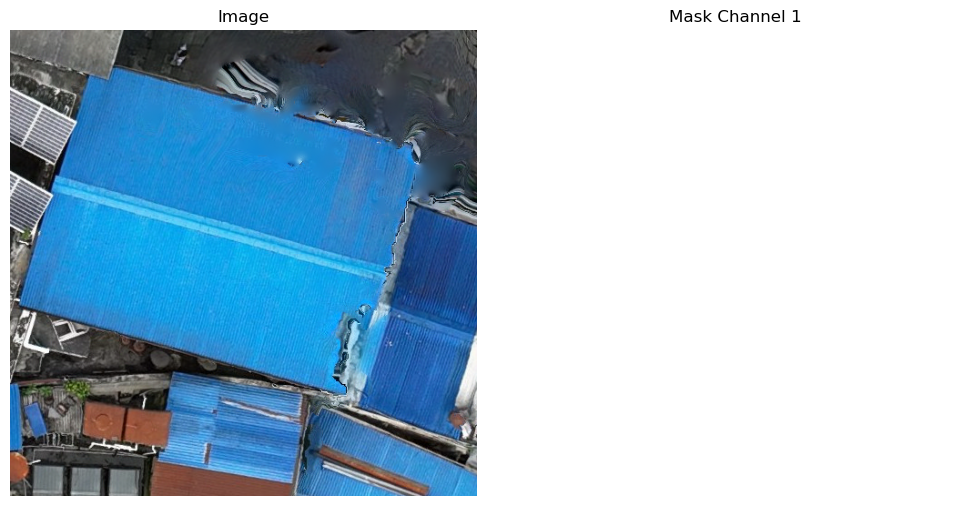

Image shape (bands, height, width): (4, 513, 513)
Mask shape (channels, height, width): (1, 513, 513)

Processing: Pokharapatch_2239.tif
Unique values in mask: [0 1]


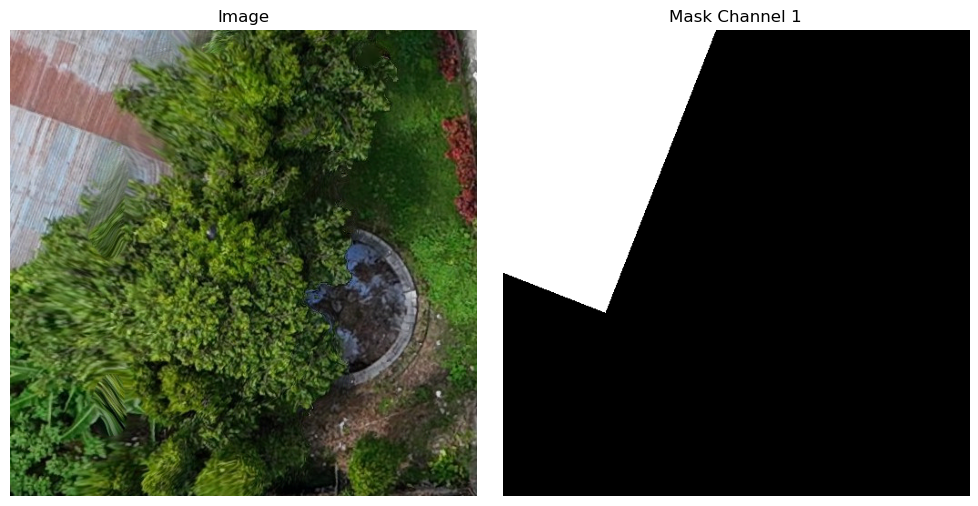

Image shape (bands, height, width): (4, 513, 513)
Mask shape (channels, height, width): (1, 513, 513)

Processing: Pokharapatch_497.tif
Unique values in mask: [0 1]


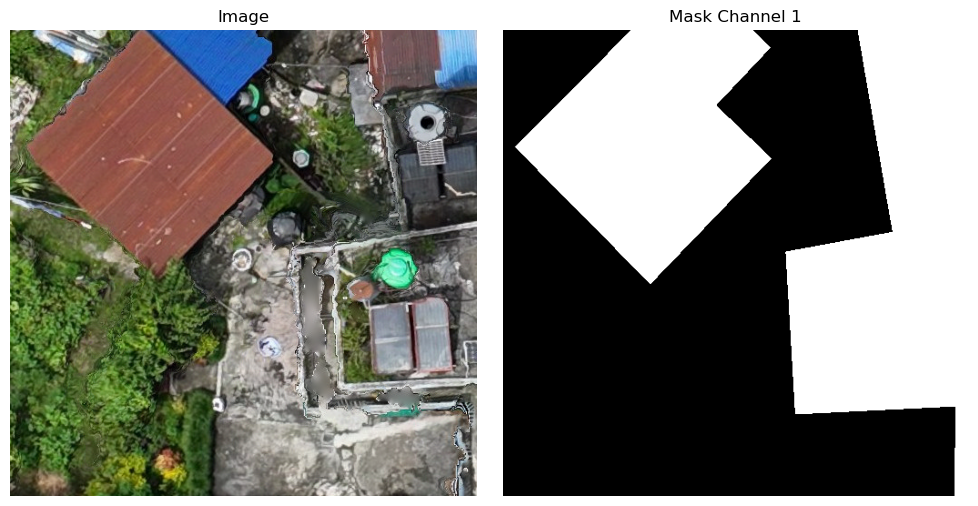

Image shape (bands, height, width): (4, 513, 513)
Mask shape (channels, height, width): (1, 513, 513)


In [6]:
import matplotlib.pyplot as plt
import os
import random
import rasterio
import numpy as np

patch_output_dir = r"D:\Drone-Image-Based-Landcover-Segmentation\output1\513x513"

# Get list of image files (tif)
image_files = [f for f in os.listdir(os.path.join(patch_output_dir, "images")) if f.endswith('.tif')]
print(f"Total image files: {len(image_files)}")

# Select 3 random images
random_image_files = random.sample(image_files, 3)

for img_file in random_image_files:
    # Construct full paths
    temp_image_path = os.path.join(patch_output_dir, "images", img_file)
    temp_mask_path = os.path.join(patch_output_dir, "masks", img_file.replace('.tif', '_mask.tif'))

    # Open image
    with rasterio.open(temp_image_path) as src:
        image = src.read().astype(float)
        image_transform = src.transform

    # Open mask
    with rasterio.open(temp_mask_path) as src:
        mask = src.read()
        mask_transform = src.transform

    print(f"\nProcessing: {img_file}")
    print("Unique values in mask:", np.unique(mask))

    # Transpose image to (rows, cols, bands)
    transposed_image = image.transpose((1, 2, 0))

    # Normalize image for visualization
    transposed_image -= transposed_image.min()
    transposed_image /= transposed_image.max()

    # Number of mask channels
    num_mask_channels = mask.shape[0]

    # Plot image and mask channels
    fig, axes = plt.subplots(1, num_mask_channels + 1, figsize=(5*(num_mask_channels + 1), 5))

    axes[0].imshow(transposed_image)
    axes[0].set_title("Image")
    axes[0].axis('off')

    for i in range(num_mask_channels):
        mask_channel = mask[i, :, :]
        visual_mask = (mask_channel * 255).astype(np.uint8)
        axes[i+1].imshow(visual_mask, cmap='gray', vmin=0, vmax=255)
        axes[i+1].set_title(f"Mask Channel {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

    print('Image shape (bands, height, width):', image.shape)
    print('Mask shape (channels, height, width):', mask.shape)


In [ ]:
print(patch_output_dir)

In [ ]:
from generator2 import NepalDataGenerator
from generator2 import NepalDataset
from utils import visualize

In [ ]:
data_path = patch_output_dir
in_channels = 4
num_classes = 4
batch_size = 4
shuffle = True

transform = transforms.Compose([
    transforms.ToTensor(),
    
])

dataset = NepalDataset(data_path, transform=transform)
print(f"Dataset size: {format(len(dataset))}")
data_generator = NepalDataGenerator(dataset, batch_size=batch_size, shuffle=shuffle)
print(f"Data generator size: {format(len(data_generator))}")

In [ ]:
no_of_images_to_show = 4 # Number of images to show from the batch

images, masks = data_generator.__next__()  # Get the batch of images and masks

if no_of_images_to_show > batch_size:
    no_of_images_to_show = batch_size

for i in range(0, no_of_images_to_show):
    image = images[i].permute(1, 2, 0).numpy()  # Access individual image and convert to numpy array
    mask = masks[i].squeeze().numpy()  # Access individual mask and convert to numpy array
    visualize(image, mask)

YOLO V8 preparation


In [ ]:
import numpy as np
import cv2
from shapely.geometry import Polygon
import tifffile


def mask_to_polygons(img_path, mask_path):
    '''
    Convierte una máscara de imagen en polígonos. Devuelve dos listas:
    - Lista de polígonos de shapely sin normalizar
    - Lista de polígonos de shapely normalizados (coordenadas entre 0 y 1)

    Args:
        img_path (str): Ruta al archivo de imagen original.
        mask_path (str): Ruta al archivo de la máscara en escala de grises.
    '''

    mask =tifffile.imread(mask_path)

    # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Calcula los contornos 
    mask = mask.astype(bool)
    #contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # convertimos los contornos a polígonos de Label Studio
    polygons = []
    normalized_polygons = []
    for contour in contours:

        # Lo meto en un try porque la extraccion de polígonos que hace el opencv a partir de la máscara
        # a veces genera polígonos de menos de 4 vértices, que no tiene sentido por no ser cerrados, 
        # provocando que falle al convertir a polígno de shapely

        try:
            polygon = contour.reshape(-1, 2).tolist()

            # normalizamos las coordenadas entre 0 y 1 porque así lo requiere YOLOv8
            normalized_polygon = [[round(coord[0] / mask.shape[1], 4), round(coord[1] / mask.shape[0], 4)] for coord in
                                  polygon]

            # Convertimos a objeto poligono de shapely (sin normalizar)
            polygon_shapely = Polygon(polygon)
            simplified_polygon = polygon_shapely.simplify(0.85, preserve_topology=True)
            polygons.append(simplified_polygon)

            # normalizdos
            normalized_polygons.append(Polygon(normalized_polygon))


        except Exception as e:
            pass

    return polygons, normalized_polygons

In [ ]:
def mask_to_polygons_per_class(img_path, mask_path):
    # Map grayscale mask values to your class indices
    class_mapping = {0: 0, 1: 1,2:2}

    mask = tifffile.imread(mask_path)

    polygons_per_class = {}
    for mask_value in np.unique(mask):
        # Look up class index using mask value, if no mapping is found then continue
        class_index = class_mapping.get(mask_value)
        if class_index is None:
            continue

        class_mask = np.where(mask == mask_value, 1, 0).astype(np.uint8)

        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


        polygons = []
        for contour in contours:
            try:
                polygon = contour.reshape(-1, 2).tolist()

                normalized_polygon = [
                    
                    [round(coord[0] / mask.shape[1], 4), round(coord[1] / mask.shape[0], 4)]
                    for coord in polygon
                ]

                if class_index not in polygons_per_class:
                    polygons_per_class[class_index] = []
                polygons_per_class[class_index].append(Polygon(normalized_polygon))

            except Exception as e:
                pass

    return polygons_per_class


In [ ]:
import os
import cv2

input_dir = os.path.join(patch_output_dir, 'masks')
output_dir = labels_output_dir

for j in os.listdir(input_dir):
    image_path = os.path.join(input_dir, j)
    polygons, normalized_polygons = mask_to_polygons(image_path, image_path)  # Separate lists for each class

    # print the polygons
    file_name_without_ext = os.path.splitext(j)[0]
    if file_name_without_ext.endswith('_mask'):
        file_name_without_ext = file_name_without_ext[:-5]

    with open('{}.txt'.format(os.path.join(output_dir, file_name_without_ext)), 'w') as f:
        for class_label in range(3):
            for polygon in normalized_polygons:
                f.write('{} '.format(class_label))  # Add class label at the beginning of each line
                if isinstance(polygon, Polygon):
                    x, y = polygon.exterior.xy
                    for i in range(len(x)):
                        f.write('{} {}\t'.format(x[i], y[i]))
                f.write('\n')


In [ ]:
import os
import cv2

input_dir = os.path.join(patch_output_dir, 'masks')
output_dir = labels_output_dir


for j in os.listdir(input_dir):
    image_path = os.path.join(input_dir, j)
    polygons_per_class = mask_to_polygons_per_class(image_path, image_path)

    # print the polygons
    file_name_without_ext = os.path.splitext(j)[0]
    if file_name_without_ext.endswith('_mask'):
        file_name_without_ext = file_name_without_ext[:-5]
    
    with open('{}.txt'.format(os.path.join(output_dir, file_name_without_ext)), 'w') as f:
        for class_label, polygons in polygons_per_class.items():
            for polygon in polygons:
                f.write('{} '.format(class_label))  # Add class label at the beginning of each line
                x, y = polygon.exterior.xy
                for i in range(len(x)):
                    f.write('{} {}\t'.format(x[i], y[i]))
                f.write('\n')

In [ ]:
# import os
# import shutil
# import numpy as np


# def split_dataset_into_train_val_test(input_folder, output_folder, ratio=(0.7, 0.15, 0.15)):
#     assert sum(ratio) == 1, "Ratios must add up to 1."

#     # Get all file names in the input folder
#     all_files = os.listdir(input_folder)
#     np.random.shuffle(all_files)

#     num_files = len(all_files)
#     train_files = all_files[:int(num_files * ratio[0])]
#     val_files = all_files[int(num_files * ratio[0]):int(num_files * (ratio[0] + ratio[1]))]
#     test_files = all_files[int(num_files * (ratio[0] + ratio[1])):]

#     # Create output directories
#     for dir in ['train', 'val', 'test']:
#         os.makedirs(os.path.join(output_folder, dir), exist_ok=True)

#     # Move files to respective directories
#     for file in train_files:
#         shutil.move(os.path.join(input_folder, file), os.path.join(output_folder, 'train', file))

#     for file in val_files:
#         shutil.move(os.path.join(input_folder, file), os.path.join(output_folder, 'val', file))

#     for file in test_files:
#         shutil.move(os.path.join(input_folder, file), os.path.join(output_folder, 'test', file))


# directories = ['images', 'labels', 'masks']
# patch_output_directory = patch_output_dir

# for directory in directories:
#     input_folder = os.path.join(patch_output_directory, directory)
#     output_folder = os.path.join(patch_output_directory, directory)
#     split_dataset_into_train_val_test(input_folder, output_folder)

In [6]:

import os
import shutil
import numpy as np

def split_dataset_into_train_val_test(input_folder_images, input_folder_masks, output_folder, ratio=(0.7, 0.15, 0.15)):
    assert sum(ratio) == 1, "Ratios must add up to 1."

    # Get all image file names in the input folder (tif)
    all_image_files = [f for f in os.listdir(input_folder_images) if f.endswith('.tif')]
    np.random.shuffle(all_image_files)

    num_files = len(all_image_files)
    train_files = all_image_files[:int(num_files * ratio[0])]
    val_files = all_image_files[int(num_files * ratio[0]):int(num_files * (ratio[0] + ratio[1]))]
    test_files = all_image_files[int(num_files * (ratio[0] + ratio[1])):]

    # Create output directories
    for dir in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_folder, 'images', dir), exist_ok=True)
        os.makedirs(os.path.join(output_folder, 'masks', dir), exist_ok=True)

    # Function to move files
    def move_files(files, subset):
        for file in files:
            base_name = os.path.splitext(file)[0]
            image_file = file
            mask_file = base_name + '_mask.tif'  # Updated for tif

            src_image_path = os.path.join(input_folder_images, image_file)
            src_mask_path = os.path.join(input_folder_masks, mask_file)
            dest_image_path = os.path.join(output_folder, 'images', subset, image_file)
            dest_mask_path = os.path.join(output_folder, 'masks', subset, mask_file)

            # Check if the mask file exists before moving
            if os.path.exists(src_mask_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_mask_path, dest_mask_path)
            else:
                print(f"Warning: Mask file {src_mask_path} not found for image file {src_image_path}. Skipping.")

    move_files(train_files, 'train')
    move_files(val_files, 'val')
    move_files(test_files, 'test')

# Directories
patch_output_directory = patch_output_dir  # your patches folder

input_folder_images = os.path.join(patch_output_directory, 'images')
input_folder_masks = os.path.join(patch_output_directory, 'masks')

split_dataset_into_train_val_test(input_folder_images, input_folder_masks, patch_output_directory)




In [ ]:
# import shutil
# import os


# def merge_all_files(directory):
#     main_folders = ['images', 'labels', 'masks']
#     subfolders = ['test', 'train', 'val']

#     for main_folder in main_folders:
#         main_folder_path = os.path.join(directory, main_folder)

#         for subfolder in subfolders:
#             subfolder_path = os.path.join(main_folder_path, subfolder)

#             # merge all files in subfolder to main_folder
#             for filename in os.listdir(subfolder_path):
#                 shutil.move(os.path.join(subfolder_path, filename), main_folder_path)

#             # remove subfolder
#             shutil.rmtree(subfolder_path)
# # function call
# merge_all_files(patch_output_dir)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8m-seg.pt')

model.train(data='config.yaml', epochs=100, imgsz=512, single_cls=False,patience=30,optimizer='Adam')

In [ ]:
metrics=model.val()
# 


In [ ]:
import cv2
from ultralytics import YOLO

model_path = "C:\\Users\\bhatt\\runs\\segment\\train10\\weights\\best.pt"

image_path = "C:\\Users\\bhatt\\OneDrive\\Desktop\\semprj\\aerial-satellite-imagery-segmentation-nepal\\output\\512x512\\images\\test\\patch_1700.jpg"

img= cv2.imread(image_path)
H, W, _ = img.shape

model = YOLO(model_path)

results = model(img)

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    result.save(filename='result.jpg')  # save to disk
# 
# for result in results:
#     for j,mask in enumerate(result.masks.data):
#         mask=mask.cpu().numpy()*255
#         mask=cv2.resize(mask, (W,H))
#         visualize(img,mask)
#         print(f"Class of mask {j}: {result.masks.data.names[j]}")

In [ ]:
# import os
# import matplotlib.pyplot as plt
# import tifffile
# patch_output_dir = r'output\512x512'
# input_dir = os.path.join(patch_output_dir, 'masks')
# # output_dir = labels_output_dir

# for j in os.listdir(input_dir):
#     print(j)
#     image_path = os.path.join(input_dir, j)
#     # mask = tifffile.imread(image_path)
#     plt.imread(r"output\512x512\masks\test\patch_381_mask.jpg")
#     plt.show()
#     # image_path = os.path.join(input_dir, j)
#     # polygons, normalized_polygons = mask_to_polygons(image_path, image_path)

In [10]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to your mask file
mask_path = r"D:\output_merged\513x513\masks\test\Mission2patch_47_mask.jpg"

# Open the mask
with rasterio.open(mask_path) as src:
    mask = src.read()  # Reads all bands
    mask_meta = src.meta

# Print basic info
print("Mask shape:", mask.shape)  # (bands, height, width)
print("Number of channels (bands):", mask.shape[0])

# Optionally, check unique values in each channel
for i in range(mask.shape[0]):
    unique_values = set(mask[i].flatten())
    print(f"Channel {i+1} unique values:", unique_values)
if mask.shape[0] == 1:
    plt.imshow(mask[0], cmap='gray')
    plt.title("Mask (single channel)")
    plt.colorbar()
    plt.show()
else:
    # If multi-channel, show each channel separately
    for i in range(mask.shape[0]):
        plt.imshow(mask[i], cmap='gray')
        plt.title(f"Mask Channel {i+1}")
        plt.colorbar()
        plt.show()    


Mask shape: (1, 513, 513)
Number of channels (bands): 1
Channel 1 unique values: {np.float32(0.0), np.float32(1.0)}


: 

Mask shape: (1, 513, 513)
Number of channels: 1
Channel 1 unique values: [0. 1.]


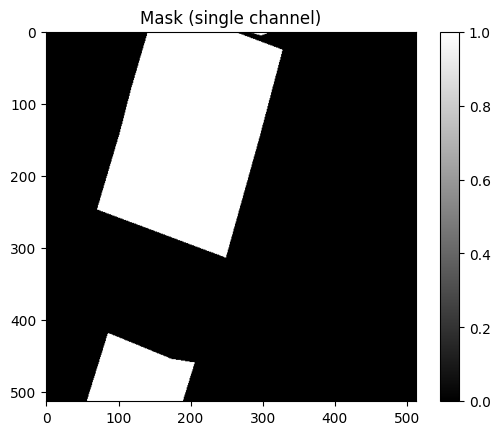

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to your mask file
mask_path = r"D:\output_merged\513x513\masks\test\Mission2patch_47_mask.jpg"

# Load the mask
with rasterio.open(mask_path) as src:
    mask = src.read()  # shape: (channels, height, width)
    mask_meta = src.meta

# Print info
print("Mask shape:", mask.shape)  # (channels, height, width)
print("Number of channels:", mask.shape[0])

# Check unique values per channel
for i in range(mask.shape[0]):
    unique_values = np.unique(mask[i])
    print(f"Channel {i+1} unique values: {unique_values}")

# Visualization
# If single channel, just show it
if mask.shape[0] == 1:
    plt.imshow(mask[0], cmap='gray')
    plt.title("Mask (single channel)")
    plt.colorbar()
    plt.show()
else:
    # If multi-channel, show each channel separately
    for i in range(mask.shape[0]):
        plt.imshow(mask[i], cmap='gray')
        plt.title(f"Mask Channel {i+1}")
        plt.colorbar()
        plt.show()


Mask shape (channels, height, width): (1, 513, 513)
Number of channels: 1

Channel 1 NumPy array:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unique values in Channel 1: [0 1]


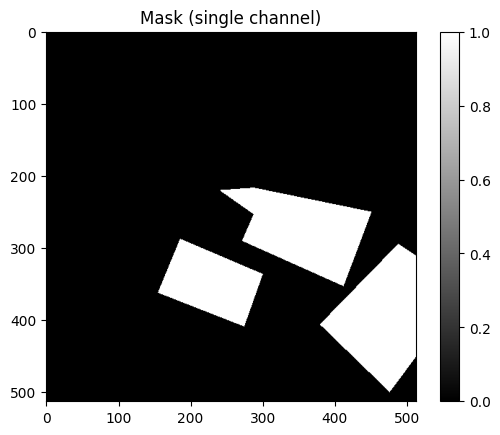

In [7]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to your mask file
mask_path = r"D:\Drone-Image-Based-Landcover-Segmentation\output\513x513\masks\train\patch_14_mask.tif"

# Load the mask
with rasterio.open(mask_path) as src:
    mask = src.read()  # shape: (channels, height, width)
    mask_meta = src.meta

# Print mask information
print("Mask shape (channels, height, width):", mask.shape)
print("Number of channels:", mask.shape[0])

# Print the NumPy matrix for each channel
for i in range(mask.shape[0]):
    print(f"\nChannel {i+1} NumPy array:\n", mask[i])
    print(f"Unique values in Channel {i+1}:", np.unique(mask[i]))

# Visualization
if mask.shape[0] == 1:
    plt.imshow(mask[0], cmap='gray')
    plt.title("Mask (single channel)")
    plt.colorbar()
    plt.show()
else:
    for i in range(mask.shape[0]):
        plt.imshow(mask[i], cmap='gray')
        plt.title(f"Mask Channel {i+1}")
        plt.colorbar()
        plt.show()


In [8]:
import torch

OSError: [WinError 127] The specified procedure could not be found. Error loading "c:\Users\Asus\anaconda3\envs\crowdcounting\lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [9]:
import torch

OSError: [WinError 127] The specified procedure could not be found. Error loading "c:\Users\Asus\anaconda3\envs\crowdcounting\lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [1]:
import torch
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from deemodel import prepare_model

def infer_single_image(model, image_path, save_path, threshold=0.5, use_channels=3, overlay_alpha=0.4):
    """
    Inference for a single GeoTIFF image and overlay mask visualization.

    Args:
        model: Trained PyTorch segmentation model
        image_path: Path to input GeoTIFF
        save_path: Path to save predicted mask
        threshold: Threshold for binary mask
        use_channels: Number of channels to use from input image (e.g., 3 for RGB)
        overlay_alpha: Transparency for overlay mask (0-1)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Load GeoTIFF
    with rasterio.open(image_path) as src:
        img = src.read()  # (C,H,W)
        meta = src.meta.copy()

    # Use only first 3 channels for RGB/model
    if img.shape[0] > use_channels:
        img = img[:use_channels, :, :]

    # Normalize to 0-1
    img = img.astype(np.float32)
    if img.max() > 1.0:
        img /= 255.0

    # Convert to tensor
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)  # (1,C,H,W)

    # Inference
    with torch.no_grad():
        output = model(img_tensor)["out"]
        output = torch.sigmoid(output)
        pred_mask = (output > threshold).float().squeeze().cpu().numpy()  # (H,W), 0/1

    # Save mask as 0-255 GeoTIFF
    pred_mask_255 = (pred_mask * 255).astype(np.uint8)
    meta.update({"count": 1, "dtype": "uint8"})
    with rasterio.open(save_path, "w", **meta) as dst:
        dst.write(pred_mask_255, 1)

    print(f"Saved prediction at {save_path}")

    # --- Prepare RGB image for visualization ---
    rgb_img = np.moveaxis(img[:3], 0, -1)  # (H,W,C)
    rgb_img_vis = (rgb_img * 255).astype(np.uint8)

    # Create red overlay
    overlay_color = np.zeros_like(rgb_img_vis)
    overlay_color[:, :, 0] = 255  # Red channel
    overlay_masked = rgb_img_vis.copy()

    # Apply overlay where mask is 1
    mask_bool = pred_mask.astype(bool)
    overlay_masked[mask_bool] = (
        (1 - overlay_alpha) * rgb_img_vis[mask_bool] + overlay_alpha * overlay_color[mask_bool]
    ).astype(np.uint8)

    # --- Display original and overlay side by side ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img_vis)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_masked)
    plt.title("Image with Red Overlay Mask")
    plt.axis("off")
    plt.show()

    return pred_mask_255


def test_model():
    # Load trained model
    model = prepare_model(num_classes=1)
    best_weights = torch.load(
        r"D:\Drone-Image-Based-Landcover-Segmentation\best_model.pth",
        map_location="cpu"
    )
    model.load_state_dict(best_weights)

    # Paths
    image_path = r"D:\Drone-Image-Based-Landcover-Segmentation\output\513x513\images\test\patch_190.tif"
    save_path = r"D:\Drone-Image-Based-Landcover-Segmentation\output\patch_10_pred.tif"

    # Run inference with overlay
    infer_single_image(model, image_path, save_path, use_channels=3, overlay_alpha=0.4)


if __name__ == "__main__":
    test_model()


Saved prediction at D:\Drone-Image-Based-Landcover-Segmentation\output\patch_10_pred.tif


: 